In [1]:
import numpy as np 
import pandas as pd 
import os
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils    

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
image_dir="/content/gdrive/My Drive/Colab Notebooks/dataset/"

In [3]:
os.makedirs('/content/gdrive/My Drive/Colab Notebooks/dataset/augmented-images')
os.makedirs('/content/gdrive/My Drive/Colab Notebooks/dataset/augmented-images/yes')
os.makedirs('/content/gdrive/My Drive/Colab Notebooks/dataset/augmented-images/no')

In [4]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )
    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [5]:
augmented_data_path ='/content/gdrive/My Drive/Colab Notebooks/dataset/augmented-images/'
augment_data(file_dir=image_dir+'yes',n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
augment_data(file_dir=image_dir+'no', n_generated_samples=9, save_to_dir=augmented_data_path+'no')

In [6]:
def crop_brain_contour(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            
    
    return new_image

In [7]:
def load_data(dir_list, image_size):

    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            image = image / 255.
            X.append(image)
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [8]:
augmented_yes =augmented_data_path+'yes'
augmented_no = augmented_data_path+'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2064
X shape is: (2064, 240, 240, 3)
y shape is: (2064, 1)


In [9]:
def split_data(X, y, test_size=0.2):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [10]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [11]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 1444
number of validation examples = 310
number of test examples = 310


In [12]:
def build_model(input_shape):
    X_input = Input(input_shape) 
    X = ZeroPadding2D((2, 2))(X_input) 
    
    X = Conv2D(32, (3,3), strides = (1, 1))(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) 
    
    X = MaxPooling2D((3, 3))(X) 
    X = MaxPooling2D((3, 3))(X) 
    X = Flatten()(X) 
    X = Dense(1, activation='sigmoid')(X) 
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [13]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model=build_model(IMG_SHAPE)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 244, 244, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 242, 242, 32)      896       
_________________________________________________________________
bn0 (BatchNormalization)     (None, 242, 242, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 242, 242, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 32)        0     

In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
46/46 [==============================] - 73s 2s/step - loss: 2.9613 - accuracy: 0.5391 - val_loss: 0.6804 - val_accuracy: 0.5516
Epoch 2/20
46/46 [==============================] - 77s 2s/step - loss: 0.5033 - accuracy: 0.7658 - val_loss: 0.6877 - val_accuracy: 0.4903
Epoch 3/20
46/46 [==============================] - 73s 2s/step - loss: 0.3623 - accuracy: 0.8533 - val_loss: 0.6916 - val_accuracy: 0.4839
Epoch 4/20
46/46 [==============================] - 72s 2s/step - loss: 0.4000 - accuracy: 0.8167 - val_loss: 0.6451 - val_accuracy: 0.5323
Epoch 5/20
46/46 [==============================] - 72s 2s/step - loss: 0.2545 - accuracy: 0.9032 - val_loss: 0.5991 - val_accuracy: 0.5935
Epoch 6/20
46/46 [==============================] - 72s 2s/step - loss: 0.2242 - accuracy: 0.9133 - val_loss: 0.8488 - val_accuracy: 0.4839
Epoch 7/20
46/46 [==============================] - 72s 2s/step - loss: 0.2125 - accuracy: 0.9083 - val_loss: 0.8557 - val_accuracy: 0.5065
Epoch 8/20
46/46 [==

In [15]:
history = model.history.history

In [16]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

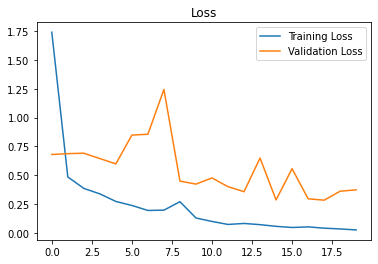

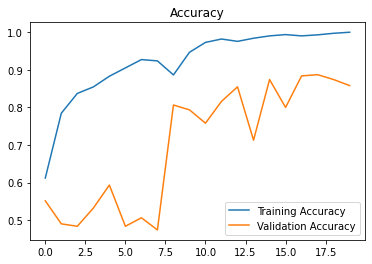

In [17]:
plot_metrics(history)

In [18]:
model.save("model.model")

INFO:tensorflow:Assets written to: model.model/assets


In [19]:
from keras.models import load_model
best_model = load_model(filepath="model.model")

In [20]:
best_model.metrics_names

['loss', 'accuracy']

In [21]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

10/10 [==============================] - 4s 419ms/step - loss: 0.3172 - accuracy: 0.8871


In [22]:
def classify(img_file):
  x = np.expand_dims(img_file, axis=0)
  result=best_model.predict(x)
  a=result[0][0]
  if a>0.7:
    print("1 - Tumourous")
  else:
    print("0 - Non - Tumourous")

In [23]:
for i in X_test:
  classify(i)

1 - Tumourous
1 - Tumourous
0 - Non - Tumourous
0 - Non - Tumourous
1 - Tumourous
1 - Tumourous
0 - Non - Tumourous
0 - Non - Tumourous
0 - Non - Tumourous
1 - Tumourous
0 - Non - Tumourous
0 - Non - Tumourous
0 - Non - Tumourous
1 - Tumourous
1 - Tumourous
0 - Non - Tumourous
1 - Tumourous
1 - Tumourous
1 - Tumourous
0 - Non - Tumourous
0 - Non - Tumourous
1 - Tumourous
1 - Tumourous
1 - Tumourous
0 - Non - Tumourous
0 - Non - Tumourous
1 - Tumourous
1 - Tumourous
0 - Non - Tumourous
0 - Non - Tumourous
1 - Tumourous
1 - Tumourous
0 - Non - Tumourous
0 - Non - Tumourous
0 - Non - Tumourous
0 - Non - Tumourous
1 - Tumourous
0 - Non - Tumourous
1 - Tumourous
0 - Non - Tumourous
0 - Non - Tumourous
1 - Tumourous
1 - Tumourous
0 - Non - Tumourous
0 - Non - Tumourous
1 - Tumourous
1 - Tumourous
1 - Tumourous
1 - Tumourous
1 - Tumourous
0 - Non - Tumourous
0 - Non - Tumourous
0 - Non - Tumourous
1 - Tumourous
0 - Non - Tumourous
0 - Non - Tumourous
1 - Tumourous
1 - Tumourous
0 - Non - Tumo